In [1]:
import decode_eeg
import numpy as np
np.random.seed(42)
%load_ext autoreload
%autoreload 2

In [2]:
# Experiment setup
experiment_name1 = '1801'
experiment_name2 = '1901'
experiment_name3 = '1902'
data_dir1 = f'./data/{experiment_name1}'
data_dir2 = f'./data/{experiment_name2}'
data_dir3 = f'./data/{experiment_name3}'

exp1 = decode_eeg.Experiment(experiment_name1,data_dir1)
exp2 = decode_eeg.Experiment(experiment_name2,data_dir2)
exp3 = decode_eeg.Experiment(experiment_name3,data_dir3)

In [3]:
# Classification parameters and setup
time_window = 50
time_step = 25
trial_average = 20
n_splits = 1000
group_dict = {0:[1],1:[2],2:[3],3:[4]}
wrangl = decode_eeg.Wrangler(exp1.info['times'],time_window,time_step,trial_average,n_splits,group_dict)

sync = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2,exp3],
                                    wrangler = wrangl,
                                    train_group = [experiment_name1,experiment_name2])

clfr = decode_eeg.Classification(wrangl,sync.nsub)

In [6]:
# If you want to retrain classifiers, run this cell. Otherwise run next cell.

for isub,sub in enumerate(sync.matched_ids):
    print(isub)
    xdata,ydata = sync.load_eeg(sub)
    xdata,ydata = sync.setup_data(xdata,ydata)
    xdata_train,xdata_test,ydata_train,ydata_test = sync.group_data(xdata,ydata)
    for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_custom_split(xdata_train,xdata_test,ydata_train,ydata_test):
        y_test_shuffle = np.random.permutation(y_test)
        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

# Set up interp object and save results.
interp = decode_eeg.Interpreter(clfr, subtitle = f'single_feature_to_conj_trialbin{trial_average}_')
interp.save_results()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [4]:
# Set up interp object and load pre-existing results. Skip if you ran previous cell.
interp = decode_eeg.Interpreter()
interp.load_results('single_feature_to_conj_trialbin20.pickle')

Saving output\figures\acc_sing_to_conj.pdf
Saving output\figures\acc_sing_to_conj.png


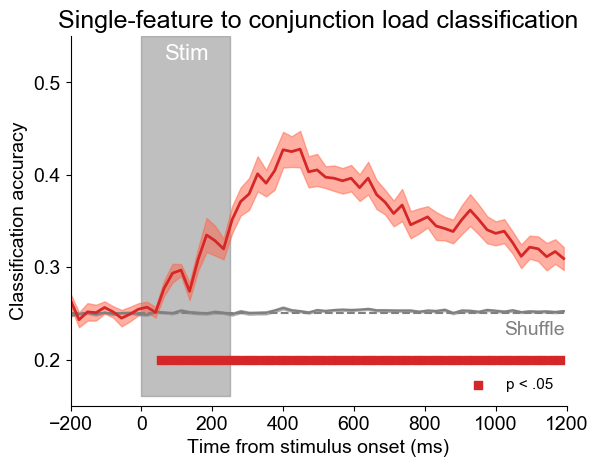

Significant timepoints: [  64   88  112  136  160  184  208  232  256  280  304  328  352  376
  400  424  448  472  496  520  544  568  592  616  640  664  688  712
  736  760  784  808  832  856  880  904  928  952  976 1000 1024 1048
 1072 1096 1120 1144 1168 1192]
Mean delay accuracy: 0.36493031249999996
Mean delay S.D.: 0.03364307502505376


In [7]:
interp.plot_acc(
    significance_testing=True,
    ylim=[.15,.55],
    chance_text_y=.23,
    title = f'Single-feature to conjunction load classification',
    subtitle='_sing_to_conj',
    savefig=True)

# Compare within to across

In [6]:
interp_sing_to_conj = decode_eeg.Interpreter()
interp_sing_to_conj.load_results(filename = 'single_feature_to_conj_trialbin20.pickle')

interp_conj = decode_eeg.Interpreter()
interp_conj.load_results('1902_trialbin20.pickle')

In [7]:
# loading sync to get ids used in single feature cross-training
wrangl = decode_eeg.Wrangler(exp1.info['times'],1,5,1,1,{})
sync = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2,exp3],
                                    wrangler = wrangl,
                                    train_group = [experiment_name1])
matched_ids = np.array(sync.matched_ids)                                    

In [8]:
unique_ids = []
for isub in range(exp3.nsub):
    info = exp3.load_info(isub)
    unique_ids.append(int(info['unique_id']))
unique_ids = np.array(unique_ids)

matched_idx = np.in1d(unique_ids,matched_ids)
interp_conj.acc = interp_conj.acc[matched_idx]
interp_conj.acc_shuff = interp_conj.acc_shuff[matched_idx]

In [9]:
# Combine acc matrices for plotting
interp_conj.acc = np.concatenate([interp_conj.acc[:,np.newaxis],interp_sing_to_conj.acc[:,np.newaxis]],1)
interp_conj.acc_shuff = np.concatenate([interp_conj.acc_shuff[:,np.newaxis],interp_sing_to_conj.acc_shuff[:,np.newaxis]],1)

Within session conjunction significant timepoints: [  64   88  112  136  160  184  208  232  256  280  304  328  352  376
  400  424  448  472  496  520  544  568  592  616  640  664  688  712
  736  760  784  808  832  856  880  904  928  952  976 1000 1024 1048
 1072 1096 1120 1144 1168 1192]
Within session conjunction mean delay accuracy: 0.40454437500000007
Within session conjunction mean delay S.D.: 0.042239991679204184
Single feature to conjunction significant timepoints: [  64   88  112  136  160  184  208  232  256  280  304  328  352  376
  400  424  448  472  496  520  544  568  592  616  640  664  688  712
  736  760  784  808  832  856  880  904  928  952  976 1000 1024 1048
 1072 1096 1120 1144 1168 1192]
Single feature to conjunction mean delay accuracy: 0.36493031249999996
Single feature to conjunction mean delay S.D.: 0.03364307502505376


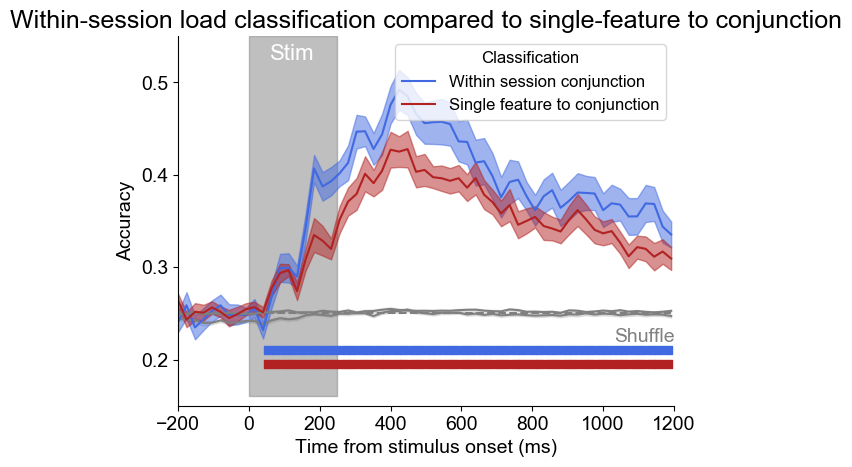

In [10]:
interp_conj.plot_acc_subset(
    subset_list=['Within session conjunction','Single feature to conjunction'],
    ylim=[.15,.55], 
    chance=.25, 
    sig_ys=[.21,.195], 
    chance_text_y=.211,
    significance_testing=True,
    title='Within-session load classification compared to single-feature to conjunction',
    subtitle='within_to_sing_to_conj',
    savefig=False)